## Imports and Helper Functions

In [1]:
RE_RUN_CELLS = False

import sys
#Path to Trane for imports
sys.path.append('/Users/Alexander/Documents/Trane/Trane__HDI_REPO')
path_to_datasets = '../../../Trane__Local_Misc/Formatted Datasets/Yelp Reviews/'
import pandas as pd
import trane
import json
import random
import datetime
import pickle
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
import scikitplot as skplt

def save_obj(obj, name):
    with open('pickled_objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    try:
        with open('pickled_objects/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        return None
def generate_probs(entity_id_column,
                            label_generating_column,
                            time_column,
                            table_meta,
                            filter_column,
                            is_pick_random_problems = True):
    generator = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    probs = []

    all_probs = list(generator.generate())

    if is_pick_random_problems:
        random.shuffle(all_probs)

    for idx, prob in enumerate(all_probs):
        probs.append(prob)
        if idx + 1 == NUM_PROBLEMS_TO_GENERATE:
            break
    prediction_problems_json = trane.prediction_problems_to_json_file(
        probs, table_meta, entity_id_column, label_generating_column, time_column, "prediction_problems.json")

    return probs

def convert(str, format = None):
    return datetime.datetime.strptime(str, format)
def file_to_table_meta(filepath):
    return trane.TableMeta(json.loads(open(filepath).read()))

## Load, Format and Sample Data (2 Minutes)

In [2]:
merged_df = load_obj('merged_df')
sampled_yelp_business_df = load_obj('sampled_yelp_business_df')
sampled_yelp_review_df = load_obj('sampled_yelp_review_df')
sampled_yelp_user_df = load_obj('sampled_yelp_user_df')
sampled_yelp_checkin_df = load_obj('sampled_yelp_checkin_df')

if  (merged_df is None or 
    sampled_yelp_business_df is None or 
    sampled_yelp_review_df is None or 
    sampled_yelp_user_df is None or
    sampled_yelp_checkin_df is None or
    RE_RUN_CELLS):
    
    yelp_review_df = pd.read_csv(path_to_datasets + 'yelp_review.csv')
    yelp_checkin_df = pd.read_csv(path_to_datasets + 'yelp_checkin.csv')
    yelp_business_df = pd.read_csv(path_to_datasets + 'yelp_business.csv')
    yelp_user_df = pd.read_csv(path_to_datasets + 'yelp_user.csv')

    sampled_yelp_review_df = yelp_review_df.head(1000)
    sampled_business_ids = sampled_yelp_review_df['business_id'].unique()
    sampled_user_ids = sampled_yelp_review_df['user_id'].unique()
    sampled_review_ids = sampled_yelp_review_df['review_id'].unique()
    sampled_yelp_checkin_df = yelp_checkin_df[yelp_checkin_df['business_id'].isin(sampled_business_ids)]
    sampled_yelp_business_df = yelp_business_df[yelp_business_df['business_id'].isin(sampled_business_ids)] 
    sampled_yelp_user_df = yelp_user_df[yelp_user_df['user_id'].isin(sampled_user_ids)]

    assert(len(sampled_business_ids) == len(sampled_yelp_business_df))
    assert(len(sampled_user_ids) == len(sampled_yelp_user_df))
    assert(len(sampled_review_ids) == len(sampled_yelp_review_df))

    print("Sampling Reuslts ---")
    print("Number of reviews: {}".format(len(sampled_yelp_review_df)))
    print("Number of businesses: {}".format(len(sampled_business_ids)))
    print("Number of users: {}".format(len(sampled_user_ids)))
    print("Number of checkins: {}".format(len(sampled_yelp_checkin_df)))

    merge_step_1 = pd.merge(sampled_yelp_review_df, sampled_yelp_user_df, how = 'left', on ='user_id')
    merge_step_2 = pd.merge(merge_step_1, sampled_yelp_business_df, how = 'left', on = 'business_id')
    merge_step_3 = pd.merge(merge_step_2, sampled_yelp_checkin_df, how = 'right', on = 'business_id')
    merged_df = merge_step_3
    merged_df['date'] = merged_df['date'].apply(str)
    merged_df['date'] = merged_df['date'].apply(convert, format = '%Y-%m-%d')
    merged_df = merged_df.rename(columns = {'stars_x': 'stars'})

    distinct_business_ids_in_merged_df = merged_df['business_id'].unique()
    #Note merged_df only contains 959 distinct business_ids. Checkins only contains information from 959 businesses.
    #    That's why merged_df only has 959 distinct business_ids, as opposed to the 974 unique business_ids 
    #    contained in the sample_yelp_review_df.
    #Note merged_df contains more than the 78792 unique check-ins because there are multiple reviews for some business_ids so
    #    each unique review_id is matched to a new business_id. There are 1000 review_ids, but only 974 business_ids.
    #
    save_obj(merged_df, 'merged_df')
    save_obj(sampled_yelp_business_df, "sampled_yelp_business_df")
    save_obj(sampled_yelp_review_df, "sampled_yelp_review_df")
    save_obj(sampled_yelp_user_df, "sampled_yelp_user_df")
    save_obj(sampled_yelp_checkin_df, "sampled_yelp_checkin_df")

## Constants

In [3]:
table_meta = file_to_table_meta(path_to_datasets + "meta.json")
entity_id_column = 'business_id'
label_generating_column = 'stars'
time_column = 'date'
filter_column = 'user_id'
NUM_PROBLEMS_TO_GENERATE = 100
prediction_problems_filename = "../../JSON Files/yelp_prediction_problems.json"

## Generate Prediction Problems

In [4]:
from trane.core.prediction_problem import select_by_diversity

problems = load_obj('problems')
if (problems is None or
    RE_RUN_CELLS):
    problem_generator_obj = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    problem_generator = problem_generator_obj.generate(merged_df)
    problems = []
    problems = list(problem_generator)
    trane.prediction_problems_to_json_file(problems, table_meta, 
                                           entity_id_column, label_generating_column, 
                                           time_column, 
                                           prediction_problems_filename)
    save_obj(problems, 'problems')

## Generate Labels (10 Minutes)

In [5]:
labels = load_obj('labels')
if (labels is None or
    RE_RUN_CELLS):
    labeler = trane.Labeler()
    entity_to_data_dict = trane.df_group_by_entity_id(merged_df, entity_id_column)
    training_cutoff_time = datetime.date(2012, 1, 1)
    label_cutoff_time = datetime.date(2015, 1, 1)
    #First date: 2007-06-12
    #Last date: 2017-12-10
    entity_to_data_and_cutoff_dict = trane.ConstantCutoffTime(
                                        training_cutoff_time, label_cutoff_time
                                    ).generate_cutoffs(entity_to_data_dict, time_column)
    labels = labeler.execute(entity_to_data_and_cutoff_dict, prediction_problems_filename)
    
    save_obj(labels, 'labels')

## Deep Feature Synthesis with Feature Tools (3 Minutes)

In [6]:
training_features_matrix = load_obj('training_features_matrix')
test_features_matrix = load_obj('test_features_matrix')
sampled_business_ids = merged_df[entity_id_column].unique()
if (training_features_matrix is None or
   test_features_matrix is None or
   RE_RUN_CELLS):
    entities = {
        "business": (sampled_yelp_business_df, "business_id"),
        "reviews": (sampled_yelp_review_df, "review_id"),
        "users": (sampled_yelp_user_df, "user_id"),
        "checkins": (sampled_yelp_checkin_df, "checkin_id")
    }
    relationships = [
        ("business", "business_id", "reviews", "business_id"),
        ("users", "user_id", "reviews", "user_id"),
        ("business", "business_id", "checkins", "business_id")
    ]

    #----FEATURES FOR TRAINING----#
    training_features_cutoff_times = pd.DataFrame([[_, training_cutoff_time] for _ in sampled_business_ids], columns = ['business_id', 'cutoff_time'])

    training_features_matrix, training_feature_definitions = ft.dfs(entities = entities,
        relationships = relationships,
        target_entity = "business",
        cutoff_time = training_features_cutoff_times)
    training_features_matrix, training_features = ft.encode_features(training_features_matrix, training_feature_definitions)

    #----FEATURES FOR TEST----#
    test_features_cutoff_times = pd.DataFrame([[_, label_cutoff_time] for _ in sampled_business_ids], columns = ['business_id', 'cutoff_time'])

    test_features_matrix, test_feature_definitions = ft.dfs(entities = entities,
        relationships = relationships,
        target_entity = "business",
        cutoff_time = test_features_cutoff_times)
    test_features_matrix, test_features = ft.encode_features(test_features_matrix, test_feature_definitions)

    save_obj(training_features_matrix, 'training_features_matrix')
    save_obj(test_features_matrix, 'test_features_matrix')

## ATM Integration

In [7]:
"""
Note, ATM expects a csv. Each row is a training example.
    The last column is the label. The other columns are features.
"""
label = labels[0]
ATM_input_df = training_features_matrix
ATM_input_df['class'] = list(label['problem_label_excluding_data_post_label_cutoff_time'])

ATM_input_df = ATM_input_df.dropna()

ATM_input_df.to_csv('yelp_data_ATM_input.csv')

In [8]:
#MANUAL INPUT
best_model_name = 'yelp_data_ATM_input-5e023120.model'


path_to_ATM = '../../../../atm/models/'
best_model_filename = path_to_ATM + best_model_name
sys.path.append('/Users/Alexander/Documents/ATM')
import atm
import btb


In [17]:
with open(best_model_filename, 'rb') as f:
    model = pickle.load(f)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


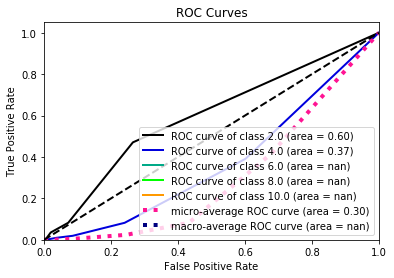

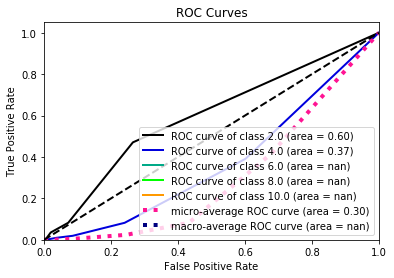

In [67]:
training_labels = label.dropna()['problem_label_excluding_data_post_label_cutoff_time']
test_labels = label.dropna()['problem_label_all_data']
test_features = test_features_matrix[test_features_matrix.index.isin(label.dropna()[entity_id_column])]
predicted_probabilities = model.pipeline.predict_proba(test_features)

indices = find_missing_label_indices(training_labels, test_labels)
predicted_probabilities = format_predicted_proba(predicted_probabilities, indices)

skplt.metrics.plot_roc_curve(test_labels, predicted_probabilities,classes = np.unique(training_labels + test_labels))
plt.show()

In [52]:
def find_missing_label_indices(train_labels, test_labels):
    """
    Finds the indices where columns of all zeros should be inserted to predicted_proba.
    
    Args
    ----------
    train_labels: the labels seen in training
    test_labels: the labels seen in testing
    
    Returns
    ----------
    indices_to_add: list of indices where a column should be inserted before each index
        to ensure all labels seen in test have a corresponding probability.
    """
    if set(test_labels).issubset(train_labels):
        return []
    train_classes = (np.unique(np.array(train_labels)))
    test_classes = (np.unique(np.array(test_labels)))
    values = np.setdiff1d(test_classes, train_classes)
    indices_to_add = [np.where(test_classes == value)[0][0] for value in values]
    return indices_to_add
def format_predicted_proba(array, indices):
    """
    Insert the columns of all zeros into array at indices
    
    Args
    ----------
    array: array to perform insertions on
    indices: the indices before which a column of zeros should be inserted
    
    Returns
    ----------
    array: updated array with columns of all zeros inserted
    """
    if indices is None:
        return array
    indices_before_len = [idx for idx in indices if idx <= array.shape[1]]
    partially_filled_array = np.insert(array, indices_before_len, 0, axis = 1)
    num_indices_after_len = len(indices) - len(indices_before_len)
    arr_to_append = np.zeros((array.shape[0], num_indices_after_len))
    return np.append(partially_filled_array, arr_to_append, axis = 1)

In [62]:
predicted_probabilities.shape

(959, 5)

In [63]:
test_labels.shape

(639,)

In [60]:
training_labels.unique()

array([ 3.,  4.,  2., nan,  5.,  1.])